In [1]:
#-------------------------
# Import all Modules
#-------------------------

import rospy
import math
import copy
import moveit_commander
from geometry_msgs.msg import PoseStamped
import sys

from moveit_msgs.msg import Constraints, TrajectoryConstraints
from moveit_msgs.msg import PositionConstraint
from moveit_msgs.msg import BoundingVolume
from moveit_msgs.msg import PlanningScene, ObjectColor

from std_msgs.msg import Header
from geometry_msgs.msg import Vector3, Pose
from shape_msgs.msg import SolidPrimitive

## *Initializing and Initial position setting*

In [ ]:
##--------------------
## Initialize all 
##--------------------

# Initialize
moveit_commander.roscpp_initialize(sys.argv)
rospy.init_node(name="Ur5e_mother_node", anonymous=True)

# Create an Instance
robot = moveit_commander.RobotCommander()
group_name = robot.get_group_names()[0]
manipulator = moveit_commander.MoveGroupCommander(name=group_name)
scene = moveit_commander.PlanningSceneInterface()

# ## Add Object Co-ordinates to be grasped
# object_pose = PoseStamped()
# object_pose = PoseStamped()
# object_pose.header.frame_id = robot.get_planning_frame()
# object_pose.pose.position.x = -0.505-0.15  # In meters
# object_pose.pose.position.y = 0.525
# object_pose.pose.position.z = 0.10ect_pose = PoseStamped()
# object_pose = PoseStamped()
# object_pose.header.frame_id = robot.get_planning_frame()
# object_pose.pose.position.x = -0.505-0.15  # In meters
# object_pose.pose.position.y = 0.525
# object_pose.pose.position.z = 0.10

[ERROR] [1755121147.848601176]: The kinematics plugin (manipulator) failed to load. Error: According to the loaded plugin descriptions the class trac_ik_kinematics_plugin/TRAC_IKKinematicsPlugin with base class type kinematics::KinematicsBase does not exist. Declared types are  cached_ik_kinematics_plugin/CachedKDLKinematicsPlugin cached_ik_kinematics_plugin/CachedSrvKinematicsPlugin kdl_kinematics_plugin/KDLKinematicsPlugin lma_kinematics_plugin/LMAKinematicsPlugin srv_kinematics_plugin/SrvKinematicsPlugin ur_kinematics/UR10KinematicsPlugin ur_kinematics/UR10eKinematicsPlugin ur_kinematics/UR16eKinematicsPlugin ur_kinematics/UR3KinematicsPlugin ur_kinematics/UR3eKinematicsPlugin ur_kinematics/UR5KinematicsPlugin ur_kinematics/UR5eKinematicsPlugin
[ERROR] [1755121147.848618223]: Kinematics solver could not be instantiated for joint group manipulator.


[INFO] [1755121147.829426433]: Loading robot model 'ur5e_robot'...
[INFO] [1755121148.971471532]: Ready to take commands for planning group manipulator.


In [4]:
# Clear all constraints that might remain in memory previously entered

manipulator.clear_path_constraints()

##-------------------------------------------------
# Adding work table in Rviz
##-------------------------------------------------

# Define the Pose of work table
# The table is 36 inches wide, 60 inches long and 2 inches high
# The table is placed at the center of the robot's planning frame, with the top surface
table_pose = PoseStamped()
table_pose.header.frame_id = robot.get_planning_frame()
table_pose.pose.position.x = -(36/2 - 3.5)/(39.37)
table_pose.pose.position.y = 0.0
table_pose.pose.position.z = (-2)/(2 * 39.37)

table_size = (36/39.37, 60/39.37, 2/39.37)

# Add table
scene.add_box(name="Table", pose=table_pose, size=table_size)

#--------------------------------------------------------------------
# Path Constraint for elbow crashing
#--------------------------------------------------------------------

## Instantiate each of the messages
ws_traj_constraint = TrajectoryConstraints()
ws_constraint = Constraints()
position_constraint = PositionConstraint()
ws_region = BoundingVolume()

## Configure the bounding Volume
# Define the shape and volume of the workspace region (a box within whihc the specified link here elbow will stay !! - Can be stacked upon to create constraints for planning or obstacle avoidance)
# The workspace region is a box of size 60 inches x 60 inches x 70 inches
# Convert inches to meters for the SolidPrimitive
ws_vol = SolidPrimitive(1, [60*2/39.37, 60*2/39.37, 70/39.37])

# Define the Pose of the workspace region
ws_pose = Pose()
ws_pose.position.x = -(20/2 - 3.5)/(39.37)
ws_pose.position.y = 0.0
ws_pose.position.z = (70+2)/(2 * 39.37) # The 70 + constraint box z axis location value

# Full message 
ws_region.primitives = [ws_vol]
ws_region.primitive_poses = [ws_pose]

## Configure the Position Constraint Message./src/universal_robot/ur5_moveit_config
# Sub msg - Header
header = Header()
header.stamp = rospy.Time.now()
header.frame_id = robot.get_planning_frame()

# Sub msg - Link name
# NOTE : The link axis is at the start of the link (check diagram) and lies at the center of the cylindrical tube of the link
# So for the elbow, the link is the forearm link (elbow is at the start of the link)
link_name = "forearm_link"


# Sub msg - Target_point_offset for the elbow 
# Offset along Z bcoz, we want the lower surface of the elbow to not hit the table
target_point_offset = Vector3()
target_point_offset.x = 0.0
target_point_offset.y = 0.0
target_point_offset.z = -(2) / (2 * 39.37)  # Dia / 2 of elbow


# Sub msg - weight - Can be made soft !! range = 0-1
weight = 1.0

# Full position_constraint message
# Read the Constraint message documentation "and" open it source code - to clearly identify arguments and the type to pass in ! 
position_constraint.header = header
position_constraint.link_name = link_name
position_constraint.target_point_offset = target_point_offset
position_constraint.constraint_region = ws_region
position_constraint.weight = weight


# Full Constraints msg
ws_constraint.position_constraints = [position_constraint]

# Full Trajectory Constraint message
# ws_traj_constraint.constraints = [ws_constraint] 

# Clear all Preivios comments
manipulator.clear_path_constraints()

# Set Constraints
# manipulator.set_path_constraints(ws_constraint)
manipulator.set_path_constraints(ws_constraint)

In [5]:
# Set the Initial Joint Values

best_start_joint_values = [2.9368191195029762,
 -1.1332901161660747,
 0.7350209856419379,
 -1.1729159417671136,
 -1.570922883424681,
 2.937330083407868]

manipulator.set_joint_value_target(arg1=best_start_joint_values)

# Plan the trajectory
plan_tuple = manipulator.plan()

# Execute the trajectory
success = plan_tuple[0]
plan = plan_tuple[1]

if success:
    manipulator.execute(plan)
    rospy.sleep(2)
else:
    print("Error : Planning Failed")

## *Camera Code*

In [ ]:
import sys
import rospy
import math
import time
import cv2
import numpy as np
import pyrealsense2 as rs
import geometry_msgs 
from matplotlib import pyplot as plt
from ultralytics import YOLO 
from PIL import Image
import torch

In [7]:
##----------------------------------------------------------
## First Run the camera and get the Depth and Color Images
##----------------------------------------------------------

# Initialize the pipeline class
pipeline = rs.pipeline()

# Initialize the config class
config = rs.config()
# config the depth and color stream
config.enable_stream(stream_type=rs.stream.color, width=1280, height=720, format=rs.format.rgb8, framerate=30)
config.enable_stream(stream_type=rs.stream.depth, width=1280, height=720, format=rs.format.z16, framerate=30)

# Start the stream
profile = pipeline.start(config)

# Pass up the first 100 frames to allow time for exposure 
for x in range(100):
    pipeline.wait_for_frames()

frameset = pipeline.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup
pipeline.stop()
print("Frames Captured")

## Get color and depth frames as any array
color = np.asanyarray(color_frame.get_data())
depth = np.asanyarray(depth_frame.get_data())

Frames Captured


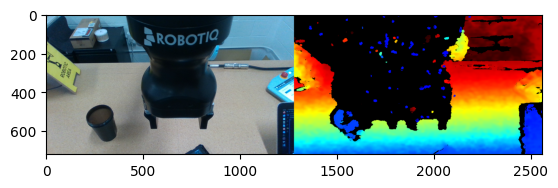

In [8]:
##----------------------------------------------------------
## Colorize depth Image and Align those Images
##----------------------------------------------------------
# Colorize depth
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())

# Align the color and depth images
align_target = rs.stream.color
align = rs.align(align_target)
frameset = align.process(frameset)

# Update the color and depth
aligned_depth_frame = frameset.get_depth_frame()
aligned_color_frame = frameset.get_color_frame()
aligned_color = np.asanyarray(aligned_color_frame.get_data())
aligned_colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Stack and show both images
images = np.hstack((aligned_color, aligned_colorized_depth))

plt.imshow(images)

##### *Doing Instance Segmentation Instead of detection*

*Semantic* : 
Classifies each pixel into a class

*Instance* : 
Classifies between different instances of a similar class of pixels

eg : Semantic - Classifies multiple pixels of different pixel as - "person"

Instance - Classifies each person as person1 person2 ...



100%|██████████| 119M/119M [00:18<00:00, 6.63MB/s] 



0: 384x640 1 cup, 1 keyboard, 386.3ms
Speed: 16.5ms preprocess, 386.3ms inference, 1166.3ms postprocess per image at shape (1, 3, 384, 640)
-------------------------------------

Object name : keyboard

-------------------------------------

Object Approximate Co-ordinates : 

Pixel_X co-ordinate : 1235.22265625

Pixel_Y co-ordinate : 581.9721069335938

Width : 88.392822265625

Height : 257.2435302734375

-------------------------------------

Object Confidence : 0.7926477193832397


-------------------------------------

-------------------------------------

Object name : cup

-------------------------------------

Object Approximate Co-ordinates : 

Pixel_X co-ordinate : 287.6175537109375

Pixel_Y co-ordinate : 561.539306640625

Width : 164.51075744628906

Height : 193.33908081054688

-------------------------------------

Object Confidence : 0.5469350218772888


-------------------------------------



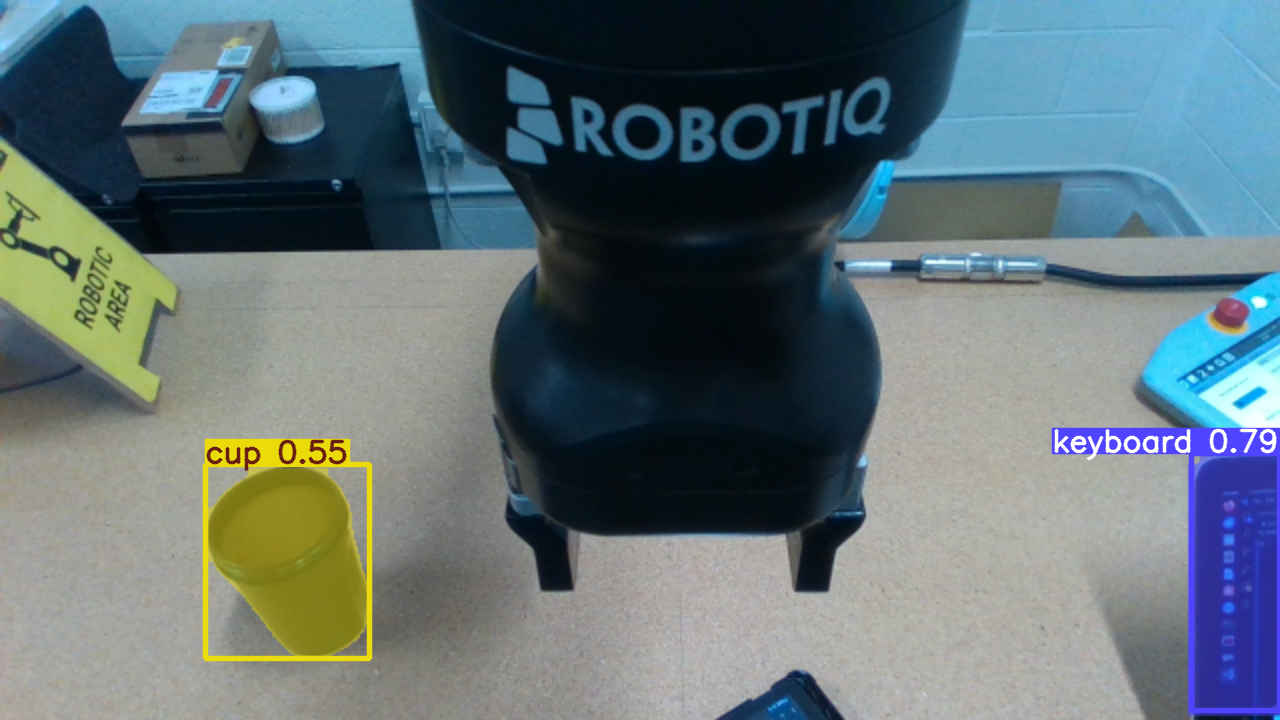

In [9]:
#----------------------------------
# Doing Instance Segmentation
#----------------------------------

# Load YOLO Segmentation model
model = YOLO("yolo11x-seg.pt")

# Make Prediction on the color image
overall_results = model.predict(aligned_color)
result = overall_results[0]
xy = result.masks.xy # Will trace the outline of the polygon
mask = result.masks.data # outputs matrix of image resolution and shows where mask is applied in that matrix

## Obtain (x,y) pixel values of the center of bounding box
detection_boxes = result.boxes
no_of_objects_detected = len(detection_boxes)


for n in range(no_of_objects_detected):
    xywh_coordinate = detection_boxes.xywh[n].tolist()
    class_id = detection_boxes.cls[n].item()
    confidence = detection_boxes.conf[n].item()
    print("-------------------------------------\n")
    print(f"Object name : {result.names[class_id]}\n")
    print("-------------------------------------\n")
    print(f"Object Approximate Co-ordinates : \n")
    print(f"Pixel_X co-ordinate : {xywh_coordinate[0]}\n")
    print(f"Pixel_Y co-ordinate : {xywh_coordinate[1]}\n")
    print(f"Width : {xywh_coordinate[2]}\n")
    print(f"Height : {xywh_coordinate[3]}\n")
    print("-------------------------------------\n")
    print(f"Object Confidence : {confidence}\n\n")
    print("-------------------------------------\n")

## Get the object detection plot:
Image.fromarray(result.plot())

#### Obtaining detection box center coordinates for comparison with the centroid

In [10]:
pixel_x = int(287.6175537109375)
pixel_y = int(561.539306640625)

# Get the color_intrinsic
color_intrinsics = aligned_color_frame.profile.as_video_stream_profile().intrinsics

pixel_depth = aligned_depth_frame.get_distance(pixel_x, pixel_y)
point = rs.rs2_deproject_pixel_to_point(color_intrinsics, [pixel_x, pixel_y], pixel_depth)

print(point)

[-0.24443034827709198, 0.1245923563838005, 0.5990000367164612]


#### Centroid calculation of the box

In [11]:
for n in range(no_of_objects_detected):
    class_id = detection_boxes.cls[n].item()

    if result.names[class_id] == "cup":
        cup_mask = result.masks.data[n]
        print(cup_mask.size())
        print('--------------\n')

        # We need to resize this mask because segmentation resizes the image to 384 x 640 by default ? - Should be able to pass in an argument to the model to not resize the image
        # But for now, we will resize the mask to the original image size of 1280 x 720
        resized_mask = cv2.resize(cup_mask.cpu().numpy(), (1280, 720), interpolation=cv2.INTER_NEAREST)
        print(resized_mask.shape)

        mask_pixel = torch.where(torch.tensor(resized_mask)>0.5)
        print(type(mask_pixel))
        print(mask_pixel)
    
    else:
        pass

row_pixel = mask_pixel[0].cpu().numpy()
col_pixel = mask_pixel[1].cpu().numpy()

# Renaming to avoid confusion
y_pixel = row_pixel
x_pixel = col_pixel


torch.Size([384, 640])
--------------

(720, 1280)
<class 'tuple'>
(tensor([462, 462, 462,  ..., 641, 641, 641]), tensor([248, 249, 250,  ..., 313, 314, 315]))


In [12]:
# For a given x_pixel, y_pixel - obtain the z_pixel - depth

# Get the color_intrinsic
color_intrinsics = aligned_color_frame.profile.as_video_stream_profile().intrinsics
depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics

xyz_pixel = []
point_3d = []

for n in range(len(x_pixel)):

    x_pixel_val = x_pixel[n]
    y_pixel_val = y_pixel[n]

    pixel_depth = aligned_depth_frame.get_distance(int(x_pixel_val), int(y_pixel_val))
    if pixel_depth == 0 or pixel_depth is None:
        continue  # Skip if depth is zero (no valid depth data) 

    xyz_pixel.append((x_pixel_val,y_pixel_val,pixel_depth))

    point = rs.rs2_deproject_pixel_to_point(depth_intrinsics, [x_pixel_val, y_pixel_val], pixel_depth)
    point_3d.append(point)

point_3d_array = np.array(point_3d)
centroid_3d = np.mean(point_3d_array, axis=0)

centroid_3d # aka Final points!

array([   -0.26537,     0.13539,     0.63567])

#### Transform the point to the camera frame

In [13]:
#----------------------------------------------------------------
# In the above code - there seems to be a mismatch between gyro and accel.
# Obtain the respective values using method call
#----------------------------------------------------------------

# Import modules
from math import atan2, sqrt, pi, asin
import pyrealsense2 as rs
import numpy as np
import time 

# Instantiate the pipeline
pipeline = rs.pipeline()

# Instantiate config
config = rs.config()

# configure the stream
config.enable_stream(stream_type=rs.stream.gyro)
config.enable_stream(stream_type=rs.stream.accel)

# Enable the stream
profile = pipeline.start()
# Use a while loop for continuous streaming

while True:
    
    frameset = pipeline.wait_for_frames()

    # Get the respective data
    gyro = frameset.first_or_default(rs.stream.gyro).as_motion_frame().get_motion_data()
    accel = frameset.first_or_default(rs.stream.accel).as_motion_frame().get_motion_data()

    # Print them 
    print(f"Accelerometer_data : ")
    print(f"X : {accel.x : .2f}")
    print(f"Y : {accel.y : .2f}")
    print(f"Z : {accel.z : .2f}\n")
    # print(f"Gyroscope_data : {gyro}\n")

    # Assign variable to each axis in the accel data :  
    ax, ay, az = accel.x, accel.y, accel.z

    # Use arctan to get Euler angles - For derivation check handwritten notes - Deriving accelerometer equations
    theta_z = atan2(ax, ay) * 180/pi
    theta_x = asin(-az/sqrt(ax**2 + ay**2 + az**2)) * 180/pi


    print(f"Angles are : ")
    print(f"Theta_x : Roll = {theta_x: .4f}")
    print(f"Theta_z : Yaw = {theta_z: .4f}\n\n")
    # print(f"Theta_z = {theta_z: .4f}\n")

    time.sleep(1)


Accelerometer_data : 
X : -0.06
Y : -7.11
Z : -6.80

Angles are : 
Theta_x : Roll =  43.7062
Theta_z : Yaw = -179.5258


Accelerometer_data : 
X : -0.11
Y : -7.11
Z : -6.77

Angles are : 
Theta_x : Roll =  43.5798
Theta_z : Yaw = -179.1308


Accelerometer_data : 
X : -0.05
Y : -7.12
Z : -6.74

Angles are : 
Theta_x : Roll =  43.4183
Theta_z : Yaw = -179.6054


Accelerometer_data : 
X : -0.10
Y : -7.12
Z : -6.75

Angles are : 
Theta_x : Roll =  43.4579
Theta_z : Yaw = -179.2109


Accelerometer_data : 
X : -0.05
Y : -7.13
Z : -6.77

Angles are : 
Theta_x : Roll =  43.5036
Theta_z : Yaw = -179.6059


Accelerometer_data : 
X : -0.04
Y : -7.15
Z : -6.73

Angles are : 
Theta_x : Roll =  43.2590
Theta_z : Yaw = -179.6856


Accelerometer_data : 
X : -0.07
Y : -7.10
Z : -6.76

Angles are : 
Theta_x : Roll =  43.5797
Theta_z : Yaw = -179.4461


Accelerometer_data : 
X : -0.03
Y : -7.12
Z : -6.77

Angles are : 
Theta_x : Roll =  43.5434
Theta_z : Yaw = -179.7632


Accelerometer_data : 
X : -0.02


KeyboardInterrupt: 

In [ ]:
# # Experimental Values 

# test_obj_location_robot_x = 16/39.32 = 0.4069
# test_obj_location_robot_y = 11/39.32 = 0.2792

# theta_x_cam_frame = -43.5817

# Robot_origin_from_Camera : 
# The robots origin as seen from camera on stand is : 
#  [[          0]
#  [  -0.088469]
#  [     1.0012]]

# Actual_Camera_Origin_From_Robot : 
# The Camera origin as seen from Robot frame 

# array([[    -0.7543],
#        [     0.0],
#        [     0.6643]])


# Test Sample centroid location Values : 
# array([   -0.26537,     0.13539,     0.63567])


In [1]:
##----------------------------------------------------
# Calculate robots origin from camera stand position
##---------------------------------------------------- 
import numpy as np
from math import cos ,sin, pi

theta_x = -43.5817

# To find rPc_origin = R_cam_to_robot * camPr_origin

# We obtained camPr_origin previously

# Equation is  : OcOr = camOcP + R_world_to_cam * worldPOr

cam_Oc_P = np.array([[0.0],[-0.054],[0.965]]) # meters

# Define the Rotation about X - axis 
phi_0 = -theta_x * (np.pi/ 180) # Convert to radians

R_CNF_to_cam = np.array([[1, 0, 0],
                         [0, cos(phi_0), -sin(phi_0)],
                         [0, sin(phi_0), cos(phi_0)]])


# Now to use the equation to get OcOr
CNF_P_Or = np.array([[0.0],
                     [0.0],
                     [0.15]]) # 15cm = Diameter of the base of robot arm

cam_Oc_Or = cam_Oc_P + np.matmul(R_CNF_to_cam, CNF_P_Or)

print(f"The robots origin as seen from camera on stand is : \n {cam_Oc_Or}") # This is the vector from camera origin to robot origin, as seem from camera frame

The robots origin as seen from camera on stand is : 
 [[ 0.        ]
 [-0.15740823]
 [ 1.07365881]]


In [13]:
##-----------------------------------------------------------------------------------------------
# Part - II : Calculate the Rotation Matrix where robot frame is represented in Camera Frame
##-----------------------------------------------------------------------------------------------

# Step I : R_robot_to_CNF

psi1 = 90 * (pi/180) # 90 degree rotation about Z-axis
R_zCNF_psi1 = np.array([[cos(psi1), -sin(psi1), 0],
                        [sin(psi1), cos(psi1), 0],
                        [0, 0, 1]])

theta1 = -90 * (pi/180)
R_ydash_theta1 = np.array([[cos(theta1), 0, sin(theta1)],
                           [0, 1, 0],
                           [-sin(theta1), 0, cos(theta1)]])


R_robot_to_CNF = R_ydash_theta1 @ R_zCNF_psi1

R_robot_to_cam = R_CNF_to_cam @ R_robot_to_CNF

# Transformation Matrix
T_robot_to_cam = np.hstack((R_robot_to_cam, cam_Oc_Or))
T_robot_to_cam = np.vstack((T_robot_to_cam, np.array([0, 0, 0, 1])))

# Transpose the Transformation matrix 
T_cam_to_robot = np.transpose(T_robot_to_cam)

np.round(T_cam_to_robot, decimals=2)



array([[ 0.  ,  0.72,  0.69,  0.  ],
       [-0.  ,  0.69, -0.72,  0.  ],
       [-1.  , -0.  ,  0.  ,  0.  ],
       [ 0.  , -0.16,  1.07,  1.  ]])

In [21]:
obj_cam = np.reshape(np.array([-0.26537,     0.13539,     0.63567, 1]), newshape=(4,1))
obj_robot = T_cam_to_robot @ obj_cam
obj_robot/obj_robot[3]

array([[ 0.32284187],
       [-0.22101024],
       [ 0.15974777],
       [ 1.        ]])

In [25]:
# Overall Transformation

centroid_vec = np.reshape(centroid_3d, newshape=(3,1))

obj_pose_robot = r_P_camorg + np.reshape(np.matmul(R_cam_to_robot, centroid_3d), newshape=(3,1))
obj_pose_robot

array([[    -1.0945],
       [     1.2181],
       [   -0.26537]])

In [26]:
np.matmul(R_cam_to_robot, centroid_3d)

array([   -0.34014,     0.55381,    -0.26537])

In [ ]:
# ## Add Object Co-ordinates to be grasped
# object_pose = PoseStamped()
# object_pose = PoseStamped()
# object_pose.header.frame_id = robot.get_planning_frame()
# object_pose.pose.position.x = -0.505-0.15  # In meters
# object_pose.pose.position.y = 0.525
# object_pose.pose.position.z = 0.10

## Pass in the object pose to camera and perform pick and place operation

In [6]:
#---------------------------------------
# Object Pickup - Defining the Approach
#---------------------------------------

## Pre - Approach : Go above the Object Location
grasp_pose = PoseStamped()
grasp_pose.header.frame_id = robot.get_planning_frame()

# Position
grasp_pose.pose.position.x = -0.50
grasp_pose.pose.position.y = 0.43902
grasp_pose.pose.position.z = 0.30 # Stay 5cm above workpiece

# Orientation
# Import Quaternion Conversion
from tf.transformations import quaternion_from_euler
import math
roll = 0  # Rotation around X-axis
pitch = math.pi  # Rotate about Y-axis
yaw = (math.pi)/2  # Rotation around Z-axis
q = quaternion_from_euler(roll, pitch, yaw)

grasp_pose.pose.orientation.x = q[0]
grasp_pose.pose.orientation.y = q[1]
grasp_pose.pose.orientation.z = q[2]
grasp_pose.pose.orientation.w = q[3]

## Perform Pre-Approach operation
manipulator.set_pose_target(grasp_pose)
manipulator.go(wait=True)

## Put node to sleep for 5s
rospy.sleep(2)

[INFO] [1755121257.754076559]: ABORTED: FAILURE


In [8]:
#---------------------------------------
# Object Pickup - Defining the Approach
#---------------------------------------

## Pre - Approach : Go above the Object Location
grasp_pose = PoseStamped()
grasp_pose.header.frame_id = robot.get_planning_frame()

# Position
grasp_pose.pose.position.x = object_pose.pose.position.x
grasp_pose.pose.position.y = object_pose.pose.position.y
grasp_pose.pose.position.z = object_pose.pose.position.z + 0.25  # Stay 5cm above workpiece

# Orientation
# Import Quaternion Conversion
from tf.transformations import quaternion_from_euler
import math
roll = 0  # Rotation around X-axis
pitch = math.pi  # Rotate about Y-axis
yaw = (math.pi)/2  # Rotation around Z-axis
q = quaternion_from_euler(roll, pitch, yaw)

grasp_pose.pose.orientation.x = q[0]
grasp_pose.pose.orientation.y = q[1]
grasp_pose.pose.orientation.z = q[2]
grasp_pose.pose.orientation.w = q[3]

## Perform Pre-Approach operation
manipulator.set_pose_target(grasp_pose)
manipulator.go(wait=True)

## Put node to sleep for 5s
rospy.sleep(2)

NameError: name 'object_pose' is not defined

In [ ]:
#--------------------------------------------------------------
## Vertical Drop Pick up workpiece using cartesian
#--------------------------------------------------------------

## Drop Down : 
waypoints_dropdown = []

wpose_dropdown = manipulator.get_current_pose().pose

# Append the current pose to waypoints
# waypoints_dropdown.append(copy.deepcopy(wpose_dropdown))

# Dropdown pose in a for loop to create close discrete waypoints with smaller resolution
for i in range(10):  
    wpose_dropdown.position.x += 0.0
    wpose_dropdown.position.y += 0.0
    wpose_dropdown.position.z -= 0.01
    waypoints_dropdown.append(copy.deepcopy(wpose_dropdown))

# Perform a cartesian dropdown of 10cms
(plan_dropdown, fraction_dropdown) = manipulator.compute_cartesian_path(waypoints=waypoints_dropdown, eef_step=0.1, avoid_collisions=True, path_constraints=ws_constraint)

if fraction_dropdown > 0.0:
    manipulator.execute(plan_dropdown, wait=True)
    rospy.sleep(2)
else:
    print(f"Error : IK_inverse failed. Fraction : {fraction_dropdown}")

In [ ]:

#-----------------------------------------------------------------
## Lift the Object :
#-----------------------------------------------------------------

waypoints_lift = []

wpose_lift = manipulator.get_current_pose().pose

# Append the current pose to waypoints
# waypoints_lift.append(copy.deepcopy(wpose_lift))

# Dropdown pose in a for loop to create close discrete waypoints with smaller resolution
for i in range(10):  
    wpose_lift.position.x += 0.0
    wpose_lift.position.y += 0.0
    wpose_lift.position.z += 0.01
    waypoints_lift.append(copy.deepcopy(wpose_lift))

# Perform a cartesian dropdown of 10cms
(plan_lift, fraction_lift) = manipulator.compute_cartesian_path(waypoints=waypoints_lift, eef_step=0.1, avoid_collisions=True, path_constraints=ws_constraint)

if fraction_lift > 0.0:
    manipulator.execute(plan_lift, wait=True)
    rospy.sleep(2)
else:
    print(f"Error : IK_inverse failed. Fraction : {fraction_lift}")

In [ ]:
#-----------------------------------------------------
# Relocation - in Cartesian Compute
#-----------------------------------------------------

waypoint_relocate = []

# Append Current position
wpose_relocate = manipulator.get_current_pose().pose
# waypoint_relocate.append(copy.deepcopy(wpose_relocate))

# Append Goal position
wpose_relocate.position.x = -0.505-0.10
wpose_relocate.position.y = -0.525
wpose_relocate.position.z = 0.30 # 20 cm above
waypoint_relocate.append(copy.deepcopy(wpose_relocate))

# Planning and Execute
(plan_relocate, fraction_relocate) = manipulator.compute_cartesian_path(waypoints=waypoint_relocate, eef_step=0.1, avoid_collisions=True, path_constraints=ws_constraint)

if fraction_relocate > 0.0:
    manipulator.execute(plan_relocate, wait=True)
    rospy.sleep(2)
else:
    print(f"Error : IK inverse Failed, Fraction : {fraction_relocate} ")

# manipulator.set_pose_target(wpose_relocate)
# manipulator.go()

In [ ]:
#--------------------------------------------------------------
## Vertical Drop to Place the workpiece using cartesian
#--------------------------------------------------------------

## Drop Down : 
waypoints_dropdown = []

wpose_dropdown = manipulator.get_current_pose().pose

# Append the current pose to waypoints
# waypoints_dropdown.append(copy.deepcopy(wpose_dropdown))

# Dropdown pose in a for loop to create close discrete waypoints with smaller resolution
for i in range(10):  
    wpose_dropdown.position.x += 0.0
    wpose_dropdown.position.y += 0.0
    wpose_dropdown.position.z -= 0.01
    waypoints_dropdown.append(copy.deepcopy(wpose_dropdown))

# Perform a cartesian dropdown of 10cms
(plan_dropdown, fraction_dropdown) = manipulator.compute_cartesian_path(waypoints=waypoints_dropdown, eef_step=0.1, avoid_collisions=True, path_constraints=ws_constraint)

if fraction_dropdown > 0.0:
    manipulator.execute(plan_dropdown, wait=True)
else:
    print(f"Error : IK_inverse failed. Fraction : {fraction_dropdown}")

rospy.sleep(2)

In [ ]:
# Set the resting_joint_values NOTE - Isolated Rviz simulation is only accepting these values as starting point. The actual values from real robot resting joint values are not being accepted !!
resting_joint_values = [3.1499 ,-0.082,-2.8,1,0,0]

manipulator.set_joint_value_target(arg1=resting_joint_values)

# Plan the trajectory
plan_tuple = manipulator.plan()

# Execute the trajectory
success = plan_tuple[0]
plan = plan_tuple[1]

if success:
    manipulator.execute(plan)
else:
    print("Error : Planning Failed")

In [1]:
import numpy as np

In [14]:
# New Transformation matrix

# To find rPc_origin = R_cam_to_robot * camPr_origin

# We obtained camPr_origin previously

# Equation is  : OcOr = camOcP + R_world_to_cam * worldPOr

camOcP = np.array([[0.0],[-0.054],[0.965]])

# Define the Rotation about X - axis 
phi_c = 90 #NOTE : PLACE HOLDER. Get Value from accelerometer

R_world_to_cam = np.array([[1, 0, 0],
                            [0, np.cos(phi_c), -np.sin(phi_c)],
                            [0, np.sin(phi_c), np.cos(phi_c)]])


# Now to use the equation to get OcOr
worldPOr = np.array([[0.0],
                     [0.0],
                     [0.05]]) # 5cm = Radius of the base of robot arm

OcOr = OcOr = camOcP + np.matmul(R_world_to_cam, worldPOr)

In [15]:
OcOr

array([[ 0.        ],
       [-0.09869983],
       [ 0.94259632]])

In [ ]:
# Transformation Matrix - Check full derivation in handwritten notes - Deriving the transformation matrix - 3 !!

from math import cos ,sin, pi
import numpy as np

# Angles for 2 to 3
psi = -0.2926 * pi/180
theta = 180 * pi/180# Pitch
phi= 0.0585 * pi/180  # Roll

# T2_3 : 

R2_3_z = np.array([[cos(psi), -sin(psi), 0],
                   [sin(psi), cos(psi), 0],
                   [0, 0, 1]])

R2_3_y = np.array([[cos(theta), 0, sin(theta)],
                   [0, 1 ,0],
                   [-sin(theta), 0, cos(theta)]])

R2_3_x = np.array([[1, 0, 0],
                   [0, cos(phi), -sin(phi)],
                   [0, sin(phi), cos(phi)]])

P2_3origin = np.array([[0],
                      [0],
                      [0]])

R2_3 = np.matmul(R2_3_x , R2_3_y , R2_3_z)

T2_3 = np.hstack([R2_3, P2_3origin])

# Convert to homogenous Co-ordinates
array1 = np.array([[0, 0, 0, 1]])
T2_3 = np.vstack([T2_3, array1])


# Angles for 1-2 
psi2 =  -177.5887 * pi/180
theta2 = 180 * pi/180# Pitch
phi2 = 42.5067 * pi/180  # Roll

# T1_2

R1_2_z = np.array([[cos(psi2), -sin(psi2), 0],
                   [sin(psi2), cos(psi2), 0],
                   [0, 0, 1]])

R1_2_y = np.array([[cos(theta2), 0, sin(theta2)],
                   [0, 1 ,0],
                   [-sin(theta2), 0, cos(theta2)]])

R1_2_x = np.array([[1, 0, 0],
                   [0, cos(phi2), -sin(phi2)],
                   [0, sin(phi2), cos(phi2)]])

P1_2origin = np.array([[0.80],
                       [0.0],
                       [0.635]])

R1_2 = np.matmul(R1_2_x , R1_2_y , R1_2_z)

T1_2 = np.hstack([R1_2, P1_2origin])

# Convert to homogenous Co-ordinates
array1 = np.array([[0, 0, 0, 1]])
T1_2 = np.vstack([T1_2, array1])

# Overall Transformation MAtrix 

T1_3 = np.matmul(T1_2 , T2_3)

print(f"The overall transformation Matrix is : \n {T1_3}")